# 07 - Deep Learning

## 09 - AutoEncoders

![](https://images.unsplash.com/photo-1531376653594-e9bcf0f0c65b?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1056&q=80)

Photo by [Tomas Sobek](https://unsplash.com/photos/nVqNmnAWz3A)

___

This lecture is about AutoEncoders: an unsupervised Deep Learning method.

# I. Reminder: generative models

## I.1. What is generative modeling?

A generative model is a model that will try to **learn a model that represents the distribution** of the data.

A generative modeling could be, for example, the modelisation of a distribution using gaussian distributions:

![](images/gaussian_mixture.jpg)

On the graph above, the distribution of x is modeled using 3 gaussian distributions (with different mean and standard deviations).

Okay, this is just a fit you would say... so why do we call that a generative model?

Because once you have modeled your data, you can **generate new samples** according to that distribution.

For example, once you have modeled perfectly a set of images (say of digits), you can easily generate new images of digits:

![](images/digits_generation.png)

## I.2. Why generative modeling?

Why would we use generative models?

The most common reasons could be the following:
- Data compression
- Denoising
- Find latent variables
- Perform anomaly detection

Below is an example of why generative models could be used to perform anomaly detection for self driving car:
![](images/car_anomaly.png)


## I.3. Latent variable

What is a latent variable?

A latent variable is a not observable variable, that you get from other (observable) variables. A good representation is from the Myth of the Cave:

![](images/cave_myth.jpg)

On this picture, prisoners can only see the shadows: they are the reality to them. These shadows are the observable variables.

While actually, the shadows are not real objects, the real objects that explain what happens are the golden objects creating the shadows and the fire. Those golden objects and the fire are the latent variables.

When you are playing with data, you are interested in finding the latent variables, that are not necessarily the observable variables.

# II. AutoEncoder

## II.1. Encoder

Let's begin with the following question: how could I learn the latent variables of data without label?

Or in simple words, how to get a **lower dimension representation of the features**, here an image of digit 2? You already know the PCA, the encoder works in a totally different way.
![](images/encoder.png)

Here we use a **neural network** with a decreasing number of units per layer, like in the image above. This is called an **encoder**.

## II.2. Decoder

To learn this lower dimension representation `z` of the image (the so called latent space), the idea is to use a **decoder**, and to **train the model to reconstruct the original data**.
![](images/autoencoder.png)

On the image above, the model is trained to reconstruct the original image (the digit 2), after having encoded it into the latent space `z`. 

If the model is perfectly trained, you get the exact same output image. It means your latent space `z` describes perfectly your data `x`.

## II.3. Training

Let's train a simple AutoEncoder on the MNIST digits dataset!

[]

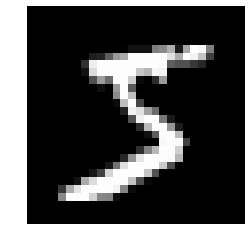

In [2]:
# Import the dataset
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Show an image
plt.imshow(X_train[0], cmap = plt.cm.gray)
plt.axis('off')
plt.plot()

In [3]:
import numpy as np

# Normalize the data
X_train = X_train/255
X_test = X_test/255 

# Reshape the data
n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [5]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

latent_dim = 32

# define the input layer: the pixel values
input_img = Input(shape=(n_pixels,))

# encode
encoded = Dense(latent_dim, activation='relu')(input_img)

# decode
decoded = Dense(n_pixels, activation='sigmoid')(encoded)

# Define the autoencoder model
autoencoder = Model(input_img, decoded)

So we have built here an autoencoder model, with only one layer with latent space of dimension 32: basically the images (of 784 pixels) will be compressed to only 32 numbers.

We can also define the decoder part and the encoder part alone:

In [6]:
# Define de encoder model
encoder = Model(input_img, encoded)

In [7]:
# Define de decoder model
# create a placeholder for an encoded 32-dimensional input
encoded_input = Input(shape=(latent_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Finally we can train the model. Notice that we **do not need the labels** `y_train`.

In [9]:
autoencoder.compile(optimizer='adam', loss='mse')

batch_size = 256

autoencoder.fit(X_train, X_train,
                epochs=5,
                batch_size=batch_size,
                validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0711 - val_loss: 0.0406
Epoch 2/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0347 - val_loss: 0.0295
Epoch 3/5
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0267 - val_loss: 0.0234
Epoch 4/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0217 - val_loss: 0.0195
Epoch 5/5
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0183 - val_loss: 0.0166


Finally, we can check how this worked!

In [10]:
# Get the predictions
X_pred = autoencoder.predict(X_test)

(-0.5, 27.5, 27.5, -0.5)

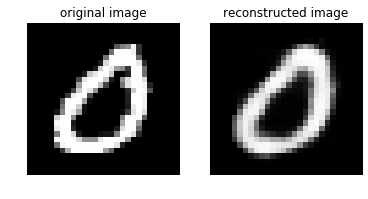

In [11]:
# Show some reconstructed images
idx = np.random.randint(X_test.shape[0])

plt.subplot(121)
plt.imshow(X_test[idx].reshape(28, 28), cmap = plt.cm.gray)
plt.title('original image')
plt.axis('off')
plt.subplot(122)
plt.imshow(X_pred[idx].reshape(28, 28), cmap = plt.cm.gray)
plt.title('reconstructed image')
plt.axis('off')

Quite impressive for just some lines of code, right? But we can do better!

# III. Variational AutoEncoder

## III.1. Latent distribution

When you run an AutoEncoder, you have no idea what the latent distribution will be. 

In simple words, your latent variables may look like nothing! But it is always better to have for example a normal distribution: values centered on 0, with a well known standard deviation right?

That's exactly what Variational AutoEncoders (VAEs) do! They force the distribution to follow a given distribution like the following:
![](images/normal_distribution.png)

## III.2. Variational AutoEncoder

So, in a VAE, we will not use directly the output of a layer to compute the latent variables `z`, but the mean (noted $\mu$) and standard deviation (noted $\sigma$):
![](images/VAE1.png)

For computational reasons, the actual formula for `z` is the following:

$$
\large z = \mu +  e^{\sigma} \epsilon
$$

Where $\epsilon$ is a random value following a normal distribution (centered on 0 with a standard deviation of 1).

Let's try to implement that using TensorFlow.

In [12]:
# Redefine the intermediate and latent dimensions
intermediate_dim = 512
latent_dim = 2
batch_size = 128

# Define the encoder part
x = Input(shape=(n_pixels,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

Now we have to define the part where `z` is computed as a function of the mean (`z_mean`) and standard deviation (`z_log_var`).

In [13]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_var) * epsilon

# Define the encoded z layer
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

Finally, define the decoder part and the VAE model:

In [14]:
# Here is the decoder part
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(n_pixels, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

## III.3. Training: the KL loss

We need to add a specific loss: indeed we do not only have to compute the difference between the input and output image, we also want to ensure a gaussian distribution for `z` (the Kullback-Leibler loss `kl_loss`).

The formula is the following, for those who like formulas:
$$
\large KL = -\frac{1}{2} \sum 1 + log(\sigma_k^2) - \sigma_k^2 - \mu_k^2
$$

Below is the implementation: no worries you do not have to know it by heart!

In [15]:
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy

def vae_loss(x, x_decoded_mean):
    classic_loss = binary_crossentropy(x, x_decoded_mean)*n_pixels
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = -0.5*K.sum(kl_loss, axis=-1)
    vae_loss = K.mean(classic_loss + kl_loss)    
    return vae_loss

Let's train the VAE now!

In [16]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

vae.fit(X_train, X_train, epochs=20,
        batch_size=batch_size, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 136us/sample - loss: 186.3885 - val_loss: 168.4068
Epoch 2/20
60000/60000 [==============================] - 10s 173us/sample - loss: 165.9021 - val_loss: 163.8503
Epoch 3/20
60000/60000 [==============================] - 10s 168us/sample - loss: 162.4330 - val_loss: 161.5842
Epoch 4/20
60000/60000 [==============================] - 10s 166us/sample - loss: 160.0634 - val_loss: 159.5280
Epoch 5/20
60000/60000 [==============================] - 10s 172us/sample - loss: 158.1044 - val_loss: 157.7759
Epoch 6/20
60000/60000 [==============================] - 10s 171us/sample - loss: 156.5799 - val_loss: 156.3031
Epoch 7/20
60000/60000 [==============================] - 10s 172us/sample - loss: 155.4241 - val_loss: 155.2005
Epoch 8/20
60000/60000 [==============================] - 11s 175us/sample - loss: 154.4978 - val_loss: 154.8988
Epoch 9/20
60000/60000 [=======================

## III.4. Latent space

Let's have a look at the latent variables!

In [17]:
# Get the predictions
X_encoded = encoder.predict(X_test)
X_encoded.shape

(10000, 2)

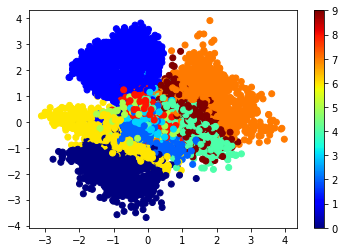

In [18]:
# Show the latent space
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

As expected, that tends to look like a distribution centered on 0, with a standard deviation close to 1. This is what the KL loss tries to ensure!

## III.5. Generating new samples

We can now generate new samples: let's generate the sample for latent variables of 0.

In [19]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

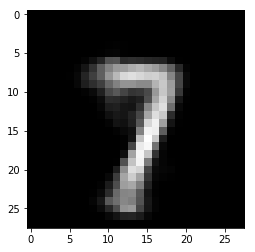

In [20]:
# generate the sample for z_mu, z_sigma = 0
generated_x = generator.predict(np.array([[1, 2]]))

plt.imshow(generated_x.reshape(28, 28), cmap = plt.cm.gray)
plt.show()

We can go through the whole latent space and display generated digits!

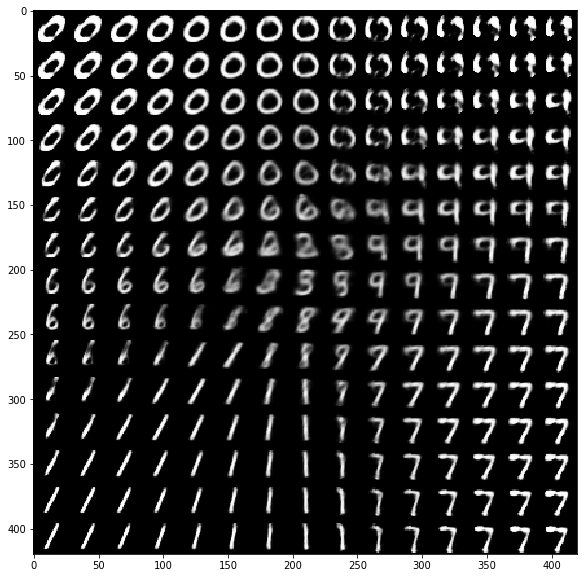

In [21]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap = plt.cm.gray)
plt.show()

Not all generated images are good, but still we generated new images of digits!

The problem is, there is no control on what digit we generate. That's where CVAEs have a role to play!

# IV. Conditional Variational AutoEncoder

## IV.1. How to generate controled samples

What if I want to generate only ones? Or only nines? Using VAE, there is no control on the generated output. Of course, this is now assuming **we do have labels**. So this is no longer unsupervised learning.

Using Conditional Variational AutoEncoder (CVAE), we add control on the generated output. 

## IV.2. Adding a condition

How to do that? Adding a condition: we will **tell the AutoEncoder what to decode**.

Now the architecture would look like that:

![](images/CVAE1.png)

As you can see, the decoder will now have the latent variables and the output target.

## IV.3. Implementation

The implementation is almost the same as the VAE, there is one slight difference: the part where we add the target value.

In [22]:
from tensorflow.keras.layers import Concatenate

# Define the number of classes: here 10 for 10 digits
n_classes = 10

# Define the encoder part
x = Input(shape=(n_pixels,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Define z
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Here is the only difference: merge latent space with labels
label = Input(shape=(n_classes,))
zc = Concatenate(axis=1)([z, label])

# Define the decoder part
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(n_pixels, activation='sigmoid')
h_decoded = decoder_h(zc)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
cvae = Model([x, label], x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model([x, label], z_mean)

In [23]:
# Put labels to one hot vectors
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

cvae.compile(optimizer='rmsprop', loss=vae_loss)

cvae.fit([X_train, y_train_cat], X_train, epochs=20,
        batch_size=batch_size, validation_data=([X_test, y_test_cat], X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 149us/sample - loss: 171.8086 - val_loss: 148.3085
Epoch 2/20
60000/60000 [==============================] - 10s 168us/sample - loss: 143.8468 - val_loss: 140.8565
Epoch 3/20
60000/60000 [==============================] - 10s 175us/sample - loss: 139.3165 - val_loss: 138.0025
Epoch 4/20
60000/60000 [==============================] - 11s 184us/sample - loss: 137.1326 - val_loss: 136.1832
Epoch 5/20
60000/60000 [==============================] - 10s 171us/sample - loss: 135.6992 - val_loss: 135.5045
Epoch 6/20
60000/60000 [==============================] - 10s 164us/sample - loss: 134.6145 - val_loss: 134.6488
Epoch 7/20
60000/60000 [==============================] - 10s 166us/sample - loss: 133.7761 - val_loss: 134.2657
Epoch 8/20
60000/60000 [==============================] - 10s 168us/sample - loss: 133.0961 - val_loss: 133.3171
Epoch 9/20
60000/60000 [=======================

## IV.4. Generating new images

Now we can generate new samples of the desired digit, let's try out!

In [24]:
# generator, from latent space and labels to reconstructed inputs
decoder_input = Input(shape=(latent_dim+n_classes,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

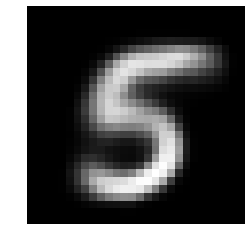

In [25]:
# Choose the digit to generate
digit_to_generate = 5

# Convert it to categorical
val = to_categorical(digit_to_generate, num_classes=n_classes)

# Create the input vector (latent value and digit class)
input_vector = np.zeros((1, latent_dim + n_classes))
input_vector[0,latent_dim:] = val

# Generate the output
generated_x = generator.predict(input_vector)

# Display the output
plt.imshow(generated_x.reshape(28, 28), cmap = plt.cm.gray)
plt.axis('off')
plt.show()

If you now want to explore more latent possibilities, you just have to change the values.

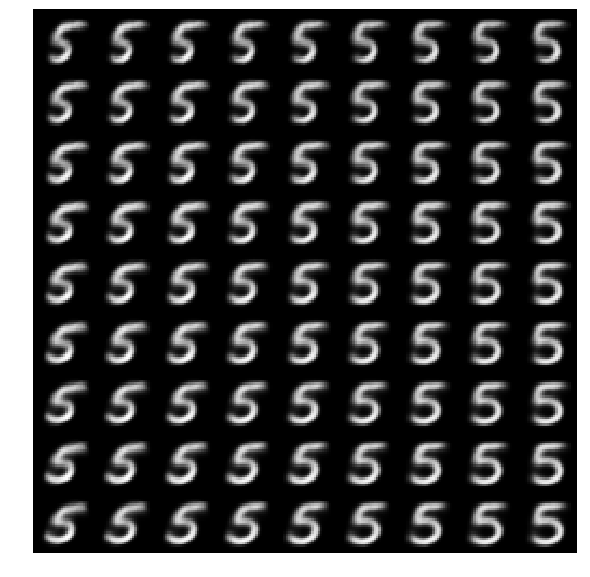

In [26]:
# display a 2D manifold of the digits
n = 9  # figure with 9x9 digits
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-0.5, 0.5, n)
grid_y = np.linspace(-0.5, 0.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Create the input vector (latent value and digit class)
        input_vector = np.zeros((1, latent_dim + n_classes))
        input_vector[0,latent_dim:] = val
        input_vector[0, 0]=xi
        input_vector[0, 1]=yi
        
        generated_x = generator.predict(input_vector)
        digit = generated_x[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap = plt.cm.gray)
plt.axis('off')
plt.show()